**Purpose:** Extract and plot the TIaaS stats

In [1]:
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import pycountry_convert as pc
import requests
import io

In [2]:
continents = {
    'NA': 'North America',
    'SA': 'South America', 
    'AS': 'Asia',
    'OC': 'Australia',
    'AF': 'Africa',
    'EU': 'Europe'
}

def get_continent(c):
    '''Extract continent name from a country code'''
    return continents[pc.country_alpha2_to_continent_code(c)]

def get_continents(c):
    '''Extract continent from country codes'''
    if '|' in c:
        cs = c.split('|')
        return '|'.join(set([get_continent(d) for d in cs]))
    else:
        return get_continent(c)

In [3]:
data_eu = pd.read_csv('https://usegalaxy.eu/tiaas/numbers.csv')
data_eu

,id,start,end,location,use_gtn,attendance
0,494,2022-05-09,2022-05-09,DE,Y,20
1,470,2022-02-22,2022-02-25,DE,Y,40
2,454,2021-12-08,2021-12-09,FR,N,22
3,455,2021-12-10,2021-12-10,FR,N,22
4,249,2019-01-16,2019-01-16,DE,Y,12
...,...,...,...,...,...,...
283,167,2018-09-25,2018-12-16,GB,Y,8
284,166,2018-09-04,2018-09-05,NL,N,25
285,165,2018-08-29,2018-08-29,NL,Y,30
286,163,2018-06-26,2018-06-26,BE,Y,15


In [4]:
data_au = pd.read_csv('https://usegalaxy.org.au/tiaas/numbers.csv')
data_au

,id,start,end,location,use_gtn,attendance
0,2,2021-02-09,2021-02-11,AU,Y,30
1,3,2021-02-09,2021-02-15,TD,Y,3
2,4,2021-02-15,2021-02-19,AU|IN|ID,Y,850
3,5,2021-03-26,2021-03-26,AU,N,60
4,6,2021-02-23,2021-02-24,AU,Y,60
5,7,2021-03-23,2021-03-23,AU,N,20
6,9,2021-03-05,2021-03-05,AU,Y,55
7,10,2021-03-18,2021-03-18,AU,N,55
8,11,2021-03-31,2021-03-31,AU,Y,20
9,12,2021-04-21,2021-04-21,AU,Y,35


In [5]:
data_us = (pd.read_csv('https://usegalaxy.org/tiaas/numbers.csv')
           .assign(
               location=lambda x: x['location']
                   .replace("\[Country\(code='","", regex=True)
                   .replace("'\)\]","", regex=True)))
data_us

,name,start,location,use_gtn,attendance
0,ccf,2022-05-05,US,Y,10
1,montpellier-2022,2022-05-18,FR,N,20


In [6]:
df = (pd.merge(data_eu, data_au, how='outer')
     .merge(data_us, how='outer')
      # transform Y / N to True / False
     .replace("Y", True)
     .replace("N", False)
     .assign(
         start=lambda x: pd.to_datetime(x['start'], format='%Y-%m-%d'),
         end=lambda x: pd.to_datetime(x['end'], format='%Y-%m-%d'),
         month=lambda x: x['start'].dt.to_period('M'),
         year=lambda x: x['start'].dt.to_period('Y'),
         continent=lambda x: [get_continents(y) for y in x['location']]))

df

,id,start,end,location,use_gtn,attendance,name,month,year,continent
0,494.0,2022-05-09,2022-05-09,DE,True,20,NaN,2022-05,2022,Europe
1,470.0,2022-02-22,2022-02-25,DE,True,40,NaN,2022-02,2022,Europe
2,454.0,2021-12-08,2021-12-09,FR,False,22,NaN,2021-12,2021,Europe
3,455.0,2021-12-10,2021-12-10,FR,False,22,NaN,2021-12,2021,Europe
4,249.0,2019-01-16,2019-01-16,DE,True,12,NaN,2019-01,2019,Europe
...,...,...,...,...,...,...,...,...,...,...
326,45.0,2022-05-06,2022-05-13,AU,False,60,NaN,2022-05,2022,Australia
327,46.0,2022-05-17,2022-05-17,AU,False,30,NaN,2022-05,2022,Australia
328,47.0,2022-05-25,2022-05-25,AU,False,10,NaN,2022-05,2022,Australia
329,NaN,2022-05-05,NaT,US,True,10,ccf,2022-05,2022,North America


# General stats

Stats collected in timeframe

In [7]:
print(f"{min(df['start'])} - {max(df['start'])}")
print(f"Number of TIaaS events: {len(df)}")
print(f"Percentage using GTN: {sum(df.use_gtn)/len(df)*100:0.2f}%")
print(f"Total Participants: {sum(df.attendance)}")

paper_sentence = f"For example, between {min(df['start']).strftime('%B %Y')} and {max(df['end']).strftime('%B %Y')}, Galaxy Europe and Galaxy Australias has been used for more than {round(len(df), -1)} training events reaching more than {round(sum(df.attendance), -1)} students."
with open("../snippets/tiaas.tex", 'w') as handle:
    handle.write(paper_sentence)

2018-06-20 00:00:00 - 2022-05-25 00:00:00
Number of TIaaS events: 331
Percentage using GTN: 64.65%
Total Participants: 17060


# Evolution over the months

In [8]:
nb_per_months_df = (df
    .groupby(df.month)
    .agg({'start': ['count'], 'attendance': ['sum']}))
nb_per_months_df.columns = ['Events', 'Participants']
nb_per_months_df.tail()

,Events,Participants
month,,
2022-01,5,74
2022-02,8,266
2022-03,17,4778
2022-04,6,135
2022-05,13,631


Average number of events per months

In [9]:
sum(nb_per_months_df.Events)/len(nb_per_months_df)

7.042553191489362

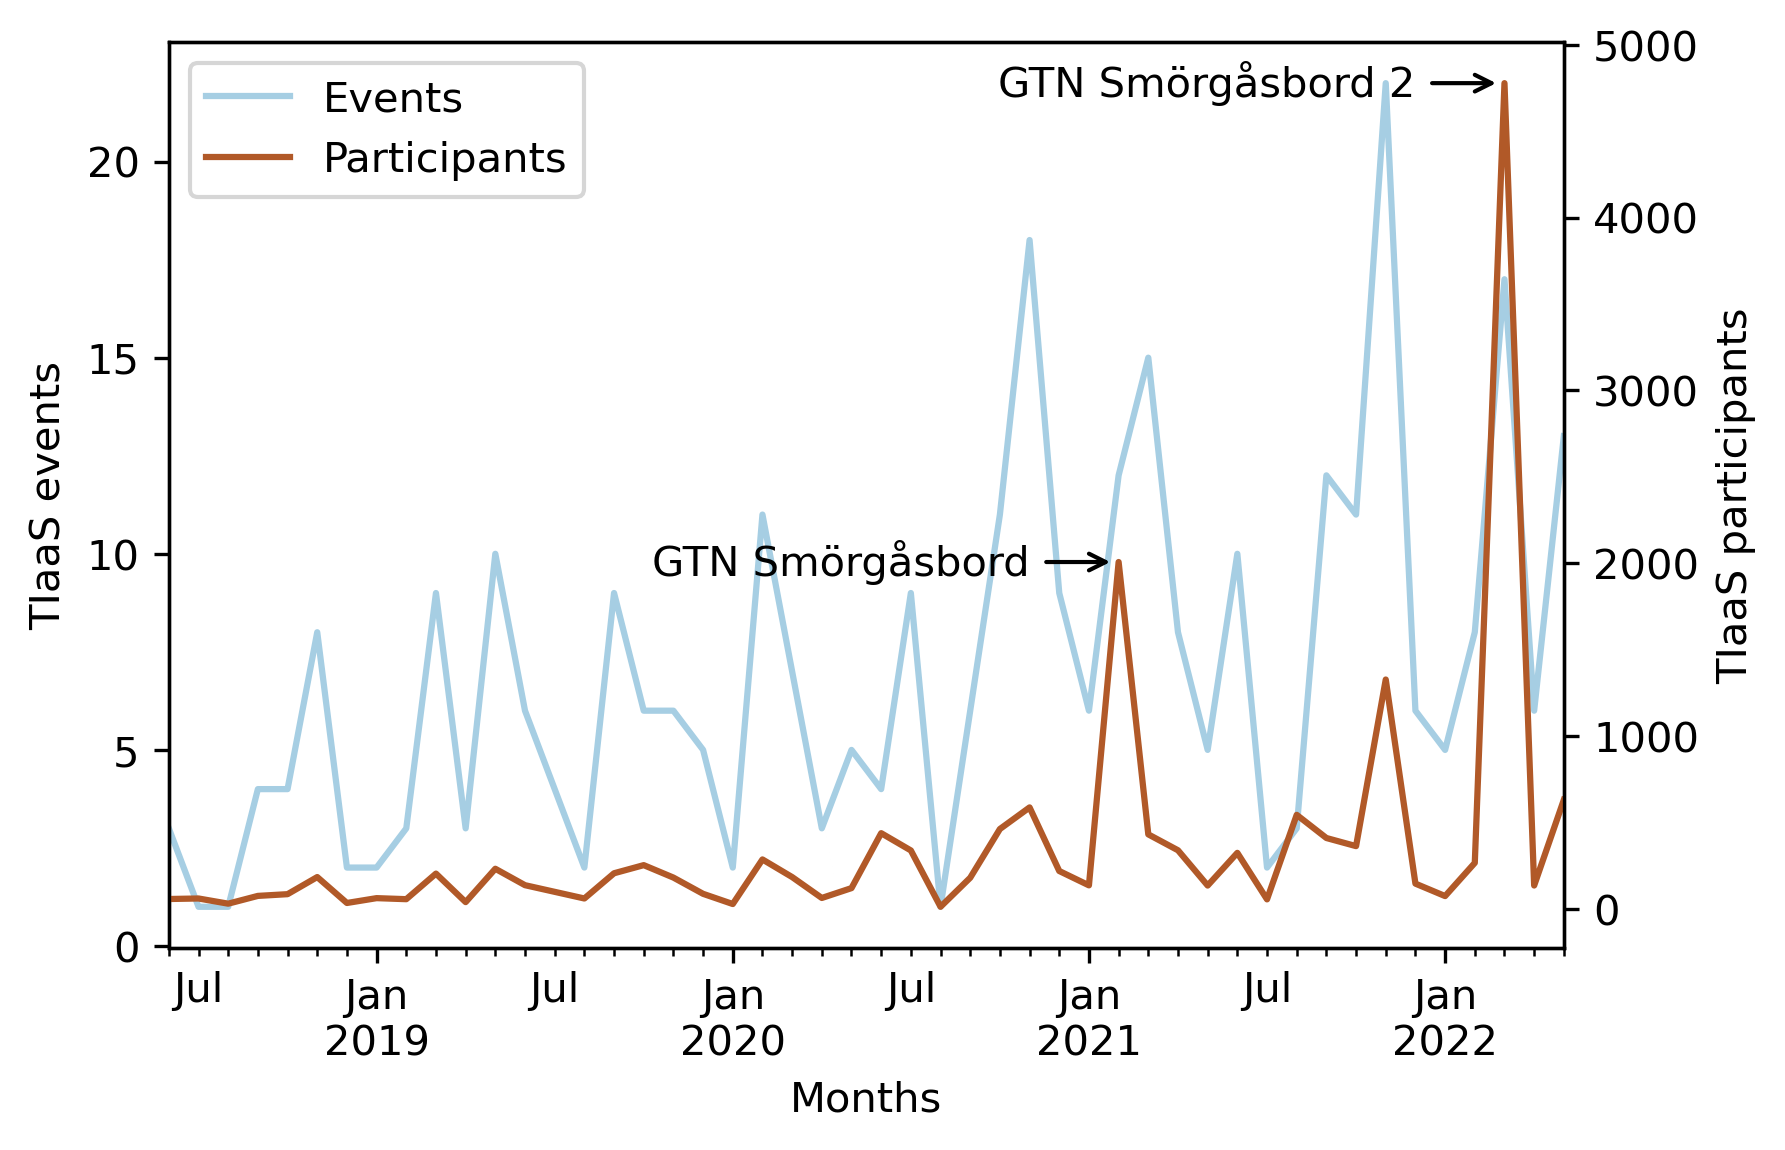

In [10]:
fig, ax = plt.subplots()
fig.set_dpi(300)

(nb_per_months_df
 .plot(colormap='Paired', secondary_y=['Participants'], mark_right=False, ax=ax)
)
ax.set_xlabel('Months')
ax.set_ylabel('TIaaS events')
ax.right_ax.set_ylabel('TIaaS participants')
plt.annotate(
    'GTN Smörgåsbord',
    xy=('2021-02-15', nb_per_months_df['Participants']['2021-02']),
    xycoords='data',
    xytext=('2020-11-01', nb_per_months_df['Participants']['2021-02']),
    arrowprops=dict(arrowstyle="->"),
    horizontalalignment='right',
    verticalalignment='center')
plt.annotate(
    'GTN Smörgåsbord 2',
    xy=('2022-03-15', nb_per_months_df['Participants']['2022-03']),
    xycoords='data',
    xytext=('2021-12-01', nb_per_months_df['Participants']['2022-03']),
    arrowprops=dict(arrowstyle="->"),
    horizontalalignment='right',
    verticalalignment='center')

plt.savefig('../images/tiaas-events.png', bbox_inches='tight')

# Location

In [11]:
nb_per_continents_df = (df
    .groupby(by='continent')
    .count()
    .filter(['start'])
    .rename(columns = {'start': 'Events'}))
nb_per_continents_df / len(df) * 100

,Events
continent,
Africa,3.323263
Asia,2.719033
Australia,15.105740
Australia|Asia,0.302115
Europe,70.996979
North America,6.948640
South America,0.604230


In [12]:
continent_year_event_df = pd.DataFrame(
    0,
    columns=list(df.continent.drop_duplicates().sort_values()) + ['Total'],
    index=['Total'] + list(df.year.drop_duplicates().sort_values(ascending=False)))
grouped_df = df.groupby(['year', 'continent'])
for g in grouped_df.groups:
    (y, c) = g
    continent_year_event_df[c][y] = len(grouped_df.get_group(g))
continent_year_event_df.loc['Total'] = continent_year_event_df.sum(axis=0)
continent_year_event_df['Total'] = continent_year_event_df.sum(axis=1)
continent_year_event_df

,Africa,Asia,Australia,Australia|Asia,Europe,North America,South America,Total
Total,11,9,50,1,235,23,2,331
2022,2,1,11,0,32,3,0,49
2021,3,6,28,1,63,11,0,112
2020,2,2,8,0,69,5,0,86
2019,3,0,2,0,52,3,1,61
2018,1,0,1,0,19,1,1,23


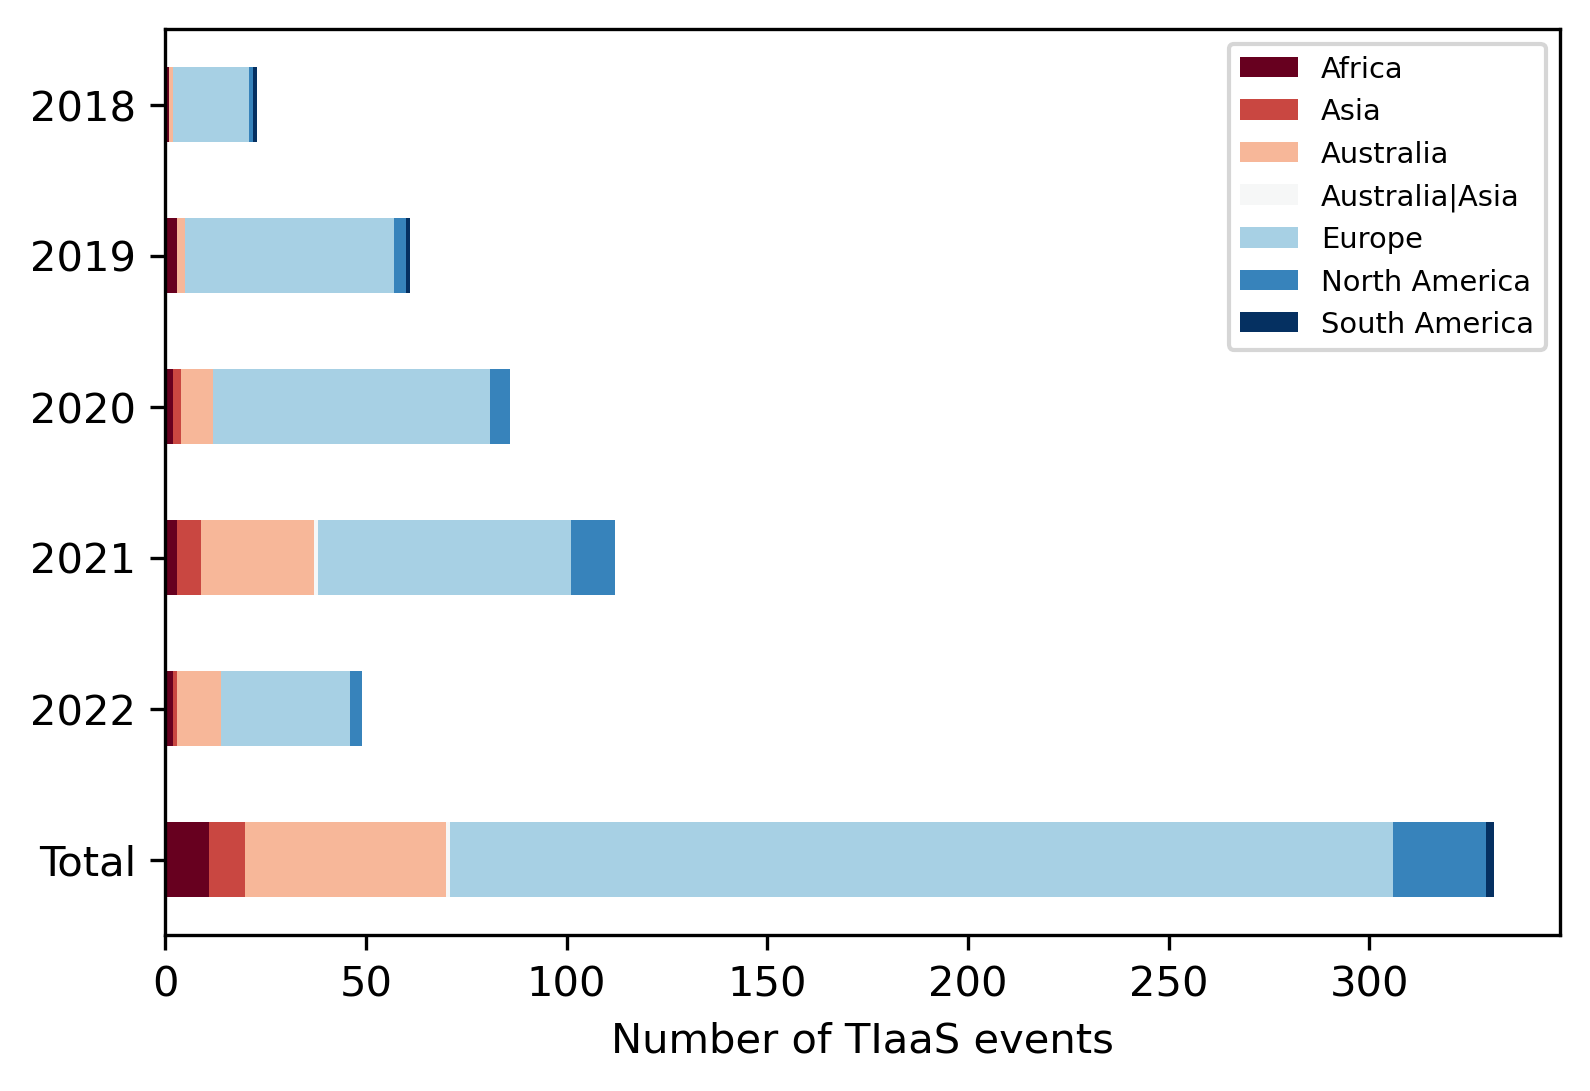

In [13]:
fig, ax = plt.subplots()
fig.set_dpi(300)
(continent_year_event_df
     .drop(['Total'], axis=1)
     .plot.barh(stacked=True, ax=ax, colormap='RdBu'))
plt.xlabel('Number of TIaaS events')
ax.legend(
    #loc='center left',
    #bbox_to_anchor=(1, 0.5),
    #frameon=False,
    fontsize='x-small')
plt.savefig('../images/tiaas-events-per-year.png', bbox_inches='tight')

In [14]:
continent_year_participants_df = pd.DataFrame(
    0,
    columns=list(df.continent.drop_duplicates().sort_values()) + ['Total'],
    index=['Total'] + list(df.year.drop_duplicates().sort_values(ascending=False)))
grouped_df = df.groupby(['year', 'continent'])
for g in grouped_df.groups:
    (y, c) = g
    continent_year_participants_df[c][y] = sum(grouped_df.get_group(g).attendance)
continent_year_participants_df.loc['Total'] = continent_year_participants_df.sum(axis=0)
continent_year_participants_df['Total'] = continent_year_participants_df.sum(axis=1)
continent_year_participants_df

,Africa,Asia,Australia,Australia|Asia,Europe,North America,South America,Total
Total,623,448,2125,850,12376,558,80,17060
2022,334,15,710,0,4770,55,0,5884
2021,48,353,1121,850,3604,241,0,6217
2020,124,80,260,0,2271,182,0,2917
2019,101,0,24,0,1332,40,20,1517
2018,16,0,10,0,399,40,60,525


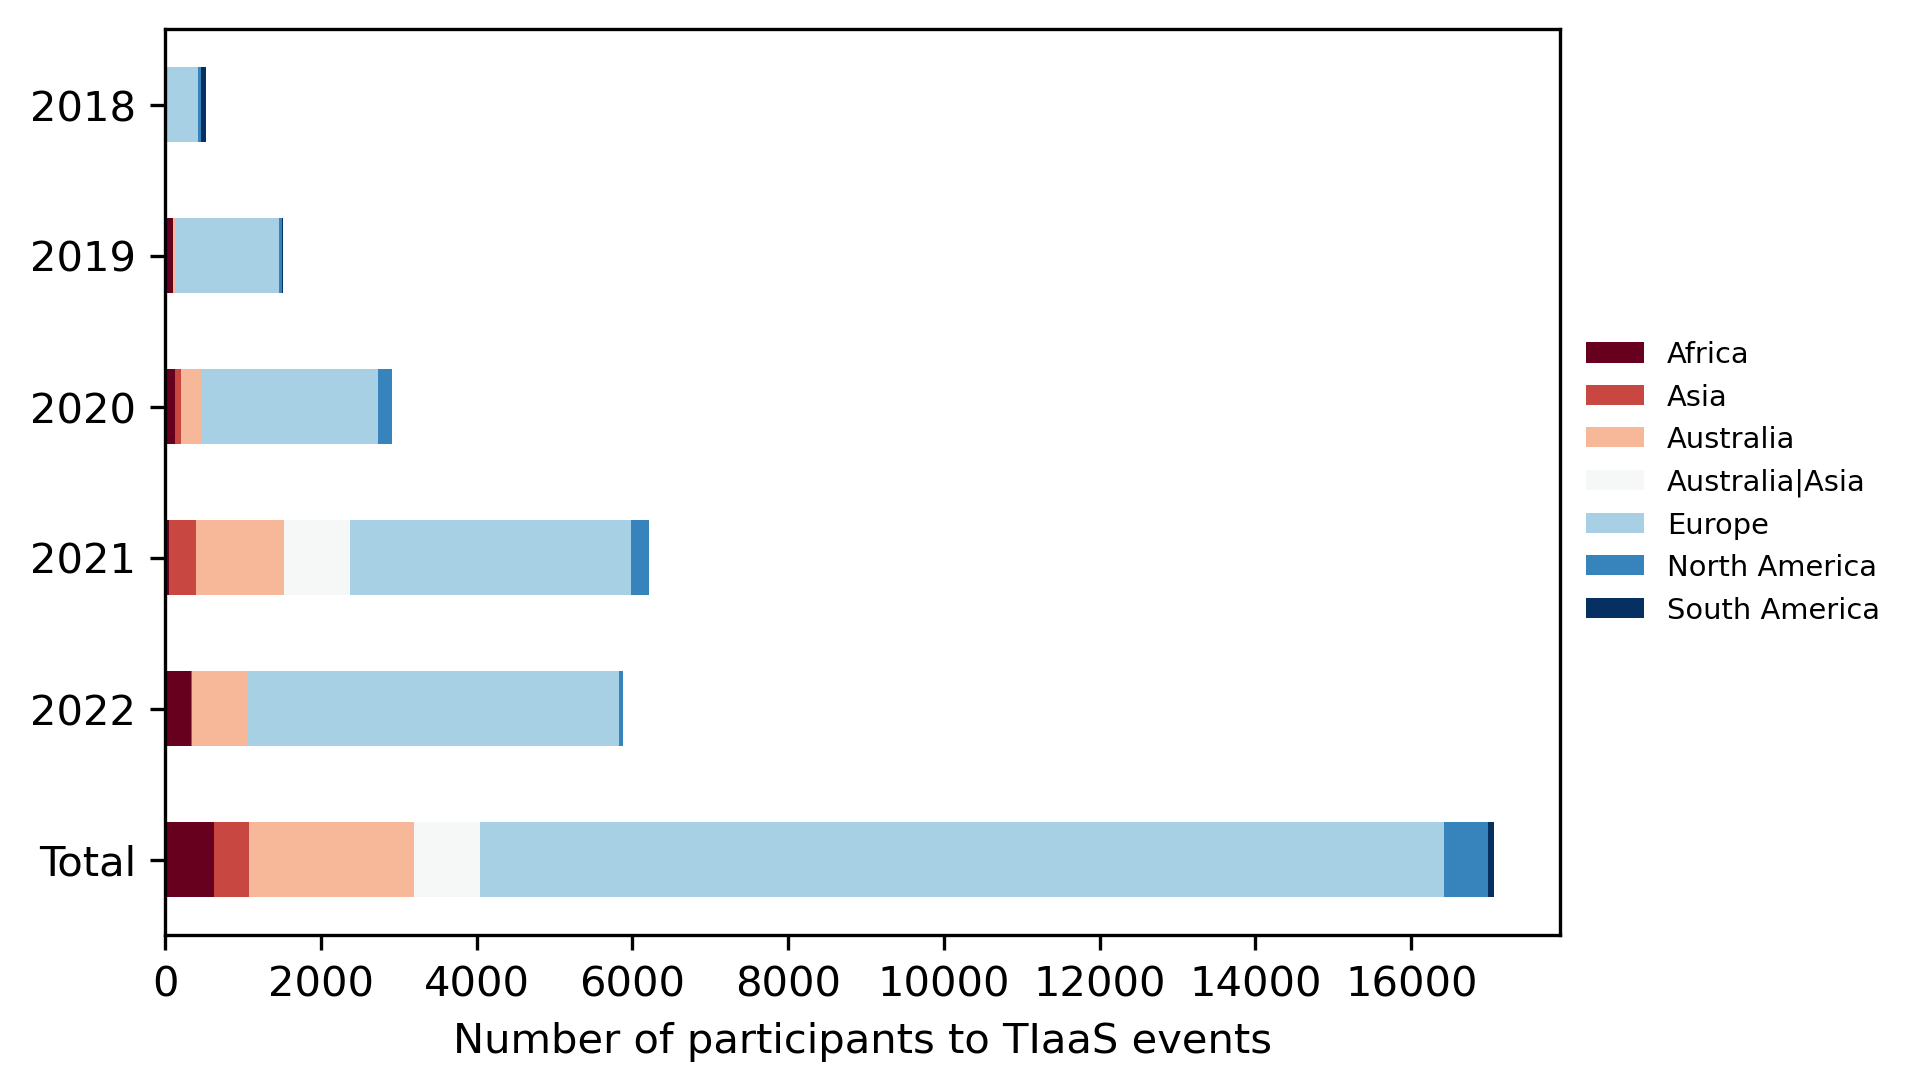

In [15]:
fig, ax = plt.subplots()
fig.set_dpi(300)
(continent_year_participants_df
     .drop(['Total'], axis=1)
     .plot.barh(stacked=True, ax=ax, colormap='RdBu'))
plt.xlabel('Number of participants to TIaaS events')
ax.legend(
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    frameon=False,
    fontsize='x-small')
plt.savefig('../images/tiaas-participants-per-year.png', bbox_inches='tight')